In [1]:
from UTILITY_quickstart import *
import yaml

with open('setLattice_defaults.yml', 'r') as file:
    importedDefaultSettings = yaml.safe_load(file)

In [2]:
csrTF = False


inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"]
tao = initializeTao(
    #inputBeamFilePathSuffix = '/beams/nmmToL0AFEND_2bunch_2024-02-16Clean/2024-02-16_2bunch_1e5Downsample_nudgeWeights.h5',
    inputBeamFilePathSuffix = inputBeamFilePathSuffix,
    
    csrTF = csrTF,
    numMacroParticles=1e4,
)





# activeSettings = importedDefaultSettings | {
#     # "S1EL_xOffset" : 0.00,  
#     # "S1EL_yOffset" : 0.0,  
#     # #"S2EL_xOffset" : 0.002,  
#     # "S2EL_yOffset" : 0.0,  
#     # "S2ER_xOffset" : 0.0,  
#     # "S2ER_yOffset" : 0.0,  
#     # "S1ER_xOffset" : 0.0,  
#     # "S1ER_yOffset" : 0.0,

#     # #"XC1FFkG" : 0.2321150061,


#     # #Sextupole compensated, CSR off
#     # "S2EL_xOffset" : 0.002, 
#     # "XC1FFkG" : 0.19,

# }
# setLattice(tao, **activeSettings)

#Rescale charge
# newCharge = 1e-9
# trackBeam(tao, trackEnd = "L0BFEND", verbose = True)
# P = getBeamAtElement(tao, "L0AFEND")
# print(f"""\n\n\nAs imported charge: {P.charge}""")
# P.charge = newCharge
# makeBeamActiveBeamFile(P)
# tao.cmd('reinit beam')

#Set aside the initial beam for later reference
trackBeam(tao, trackEnd = "L0BFEND", verbose = True)
PInit = ParticleGroup(data=tao.bunch_data("L0AFEND"))
print(f"""New charge: {PInit.charge}""")





Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR off
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_defaults.yml
Number of macro particles = 10000.0
Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = L0BFEND
Tracking!
trackBeam() exiting
New charge: 1.600000000000001e-09


In [3]:
trackBeam(tao, centerBC14 = True, centerBC20 = True, verbose = True)

Loaded activeBeamFile.h5
Set track_start = L0AFEND, track_end = end
Set track_end = BEGBC14_1
Tracking!
Beam centered at BEGBC14 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC14_1, track_end = end
Set track_end = BEGBC20
Tracking!
Beam centered at BEGBC20 written to patchBeamFile.h5
Loaded patchBeamFile.h5
Set track_start = BEGBC20, track_end = end
Tracking!
trackBeam() exiting


In [4]:
P_baseline_BEGBC20 = getBeamAtElement(tao, "BEGBC20")
P_baseline_CB1LE = getBeamAtElement(tao, "CB1LE")
P_baseline_MFFF = getBeamAtElement(tao, "MFFF")
P_baseline_PENT = getBeamAtElement(tao, "PENT")

In [5]:
savedData = {}

P = getBeamAtElement(tao, "PENT")
#PDrive, PWitness = getDriverAndWitness(P)
PDrive = P


for PActiveStr in ["PDrive"]:# , "PWitness"]:
    PActive = locals()[PActiveStr]
    for val in ["mean_x", "mean_y", "sigma_x", "sigma_y", "mean_xp", "mean_yp"]:
        savedData[f"{PActiveStr}_{val}"] = PActive[val]
        #print(f"""{PActiveStr}_{val} = {PActive[val]}""")

    #Note that this is not a standard deviation; also imposes cost for being off zero
    #savedData[f"{PActiveStr}_xCost"] = np.sqrt(np.mean((PActive.x)**2))
    #savedData[f"{PActiveStr}_yCost"] = np.sqrt(np.mean((PActive.y)**2))


    #Using the product was making it report flat beams...
    #savedData[f"{PActiveStr}_totalCost"] = savedData[f"{PActiveStr}_xCost"] * savedData[f"{PActiveStr}_yCost"]
    #Instead, average
    #savedData[f"{PActiveStr}_totalCost"] = 0.5*(savedData[f"{PActiveStr}_xCost"] + savedData[f"{PActiveStr}_yCost"])

    savedData[f"{PActiveStr}_median_x"] = np.median(PActive.x)
    savedData[f"{PActiveStr}_median_y"] = np.median(PActive.y)

    savedData[f"{PActiveStr}_median_xp"] = np.median(PActive.xp)
    savedData[f"{PActiveStr}_median_yp"] = np.median(PActive.yp)
    
    savedData[f"{PActiveStr}_sigmaSI90_x"] = smallestIntervalImpliedSigma(PActive.x, percentage = 0.90)
    savedData[f"{PActiveStr}_sigmaSI90_y"] = smallestIntervalImpliedSigma(PActive.y, percentage = 0.90)

    savedData[f"{PActiveStr}_emitSI90_x"] = smallestIntervalImpliedEmittance(PActive, plane = "x", percentage = 0.90)
    savedData[f"{PActiveStr}_emitSI90_y"] = smallestIntervalImpliedEmittance(PActive, plane = "y", percentage = 0.90)

    savedData[f"{PActiveStr}_zLen"] = smallestIntervalImpliedSigma(PActive.t * 3e8, percentage=0.9)

    savedData[f"{PActiveStr}_zCentroid"] = np.median(PActive.t * 3e8)

# savedData["bunchSpacing"] = savedData["PWitness_zCentroid"] - savedData["PDrive_zCentroid"]

# savedData["transverseCentroidOffset"] = np.sqrt(
#         (savedData["PDrive_mean_x"] - savedData["PWitness_mean_x"])**2 + 
#         (savedData["PDrive_mean_y"] - savedData["PWitness_mean_y"])**2
#     )


#savedData["lostChargeFraction"] = 1 - (tao.bunch_params("DTOTR")['n_particle_live'] / tao.bunch_params("BEGBC20")['n_particle_live'])
savedData["lostChargeFraction"] = 1 - (P.charge / PInit.charge)

/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


In [6]:
savedData

{'PDrive_mean_x': 0.0001333714308692637,
 'PDrive_mean_y': -1.4385827393902382e-07,
 'PDrive_sigma_x': 4.751704555035429e-05,
 'PDrive_sigma_y': 1.453070890405611e-05,
 'PDrive_mean_xp': -0.000525271005451444,
 'PDrive_mean_yp': 1.752730470748548e-07,
 'PDrive_median_x': 0.00012793236244732227,
 'PDrive_median_y': 2.498445140499479e-08,
 'PDrive_median_xp': -0.0005141865899558778,
 'PDrive_median_yp': -7.175082816636878e-08,
 'PDrive_sigmaSI90_x': 4.198661588133888e-05,
 'PDrive_sigmaSI90_y': 1.2187779229201647e-05,
 'PDrive_emitSI90_x': 1.8332287082603935e-05,
 'PDrive_emitSI90_y': 2.9882924881947614e-06,
 'PDrive_zLen': 2.67729328203197e-05,
 'PDrive_zCentroid': 991.3323098441202,
 'lostChargeFraction': 0.21750000000000003}

In [7]:
#print(f"""Bunch spacing: \t\t{1e6 * savedData["bunchSpacing"] :.3g} um""")

#print(f"""Transverse offset: \t{1e6*np.sqrt((savedData["PDrive_median_x"] - savedData["PWitness_median_x"])**2 + (savedData["PDrive_median_y"] - savedData["PWitness_median_y"])**2) :.3g} um""")
#print(f"""Angular misalignment: \t{1e3*np.sqrt((savedData["PDrive_median_xp"] - savedData["PWitness_median_xp"])**2 + (savedData["PDrive_median_yp"] - savedData["PWitness_median_yp"])**2) :.3g} mrad""")

print("\nEmittances and sigmas - implied by 90% charge")
print(f"""Driver emittance: \t{1e6 * savedData["PDrive_emitSI90_x"] :.3g} × {1e6 * savedData["PDrive_emitSI90_y"] :.3g} um-rad""")
#print(f"""Witness emittance: \t{1e6 * savedData["PWitness_emitSI90_x"] :.3g} × {1e6 * savedData["PWitness_emitSI90_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * savedData["PDrive_sigmaSI90_x"] :.3g}, {1e6 * savedData["PDrive_sigmaSI90_y"] :.3g}, {1e6 * savedData["PDrive_zLen"] :.3g} um""")
#print(f"""Witness sigma_x,y,z: \t{1e6 * savedData["PWitness_sigmaSI90_x"] :.3g}, {1e6 * savedData["PWitness_sigmaSI90_y"] :.3g}, {1e6 * savedData["PWitness_zLen"] :.3g} um""")



print("\nEmittances and sigmas - literal standard deviation")

print(f"""Driver emittance: \t{1e6 * PDrive["norm_emit_x"] :.3g} × {1e6 * PDrive["norm_emit_y"] :.3g} um-rad""")
#print(f"""Witness emittance: \t{1e6 * PWitness["norm_emit_x"] :.3g} × {1e6 * PWitness["norm_emit_y"] :.3g} um-rad""")

print(f"""Driver sigma_x,y,z: \t{1e6 * PDrive["sigma_x"] :.3g}, {1e6 * PDrive["sigma_y"] :.3g}, {1e6 * PDrive["sigma_z"] :.3g} um""")
#print(f"""Witness sigma_x,y,z: \t{1e6 * PWitness["sigma_x"] :.3g}, {1e6 * PWitness["sigma_y"] :.3g}, {1e6 * PWitness["sigma_z"] :.3g} um""")


Emittances and sigmas - implied by 90% charge
Driver emittance: 	18.3 × 2.99 um-rad
Driver sigma_x,y,z: 	42, 12.2, 26.8 um

Emittances and sigmas - literal standard deviation
Driver emittance: 	26 × 4.5 um-rad
Driver sigma_x,y,z: 	47.5, 14.5, 35.9 um


In [8]:
smallestIntervalImpliedEmittance(P, percentage = 0.5)

1.1338013051355768e-05

Drive:


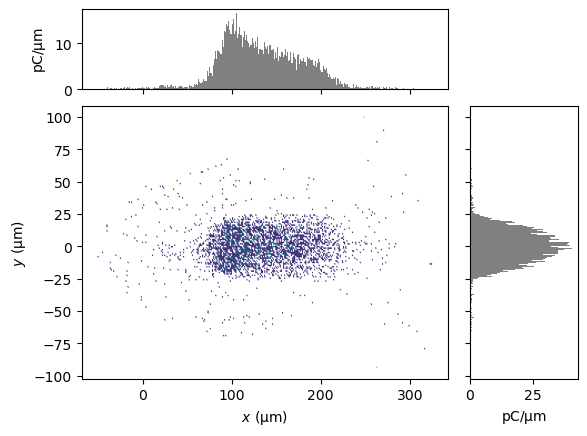

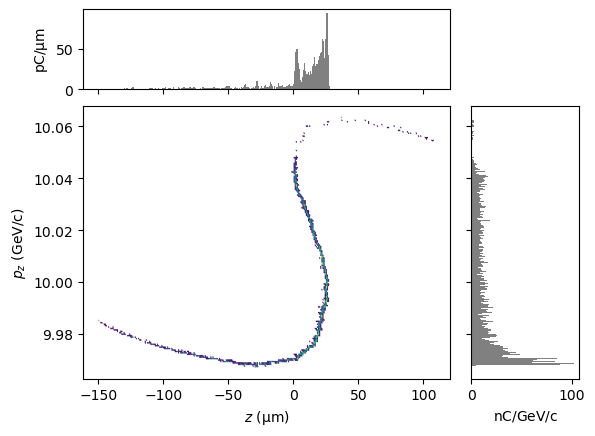

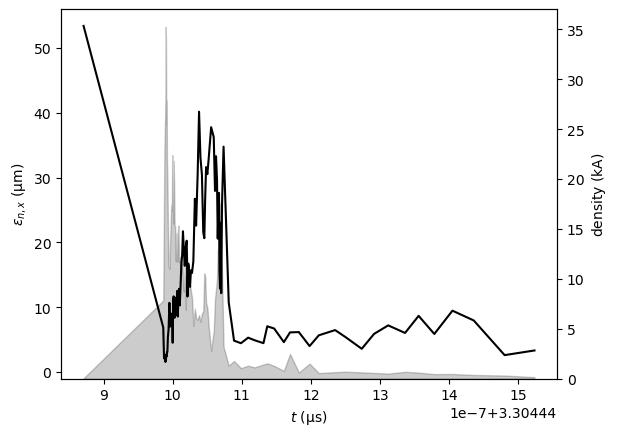

<Figure size 640x480 with 0 Axes>

In [9]:
print("Drive:")
display(plotMod(PDrive, 'x', 'y',  bins=300))
#print("Witness:")
#display(plotMod(PWitness, 'x', 'y',  bins=300))
display(plotMod(P, 'z', 'pz', bins=300))
#display(slicePlotMod(P, 'norm_emit_x', slice_key = "z", n_slice=100))
display(slicePlotMod(P, 'norm_emit_x', slice_key = "t", n_slice=100))
plt.clf()

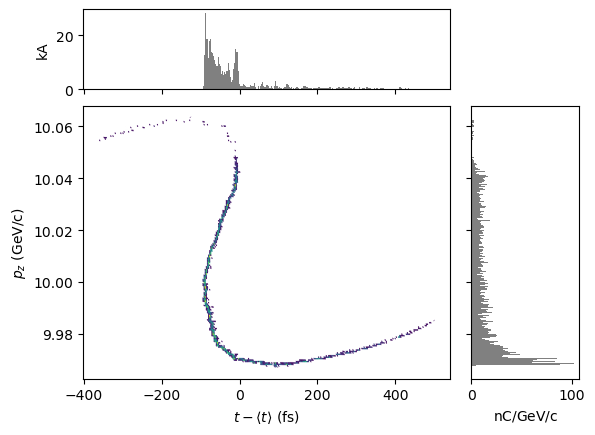

In [10]:
display(plotMod(PDrive, 'delta_t', 'pz', bins=300))

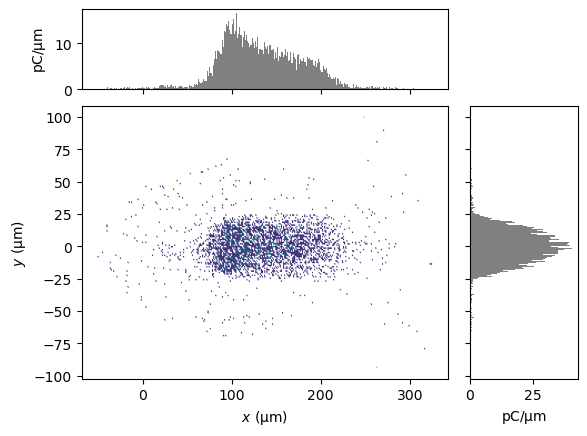

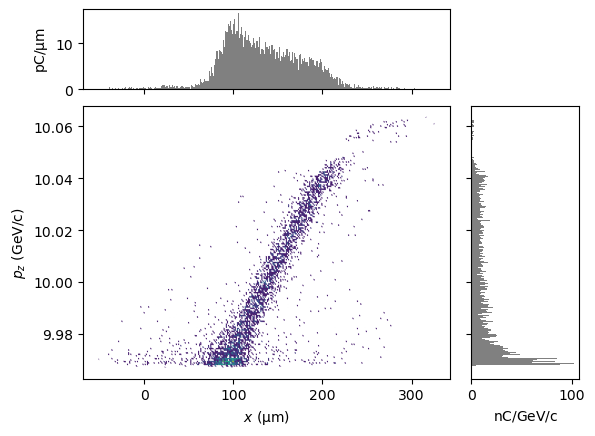

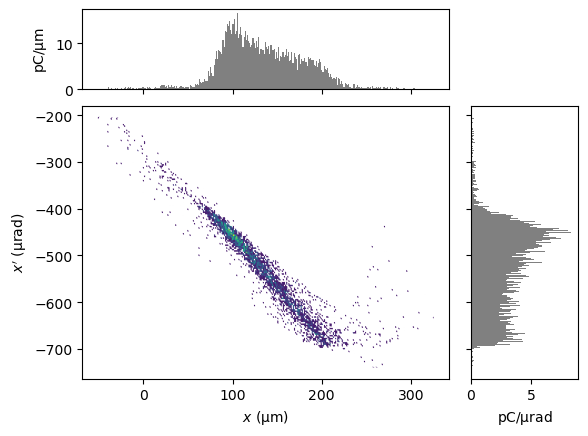

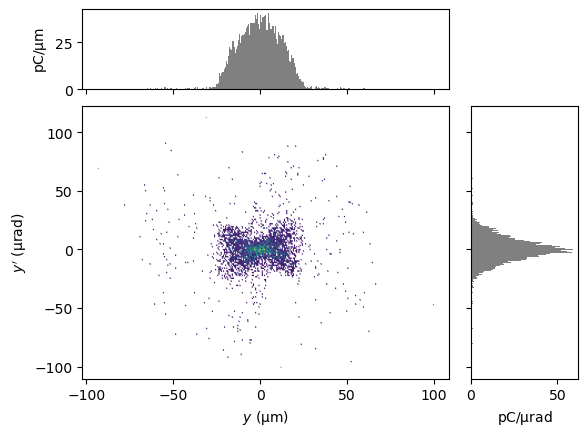

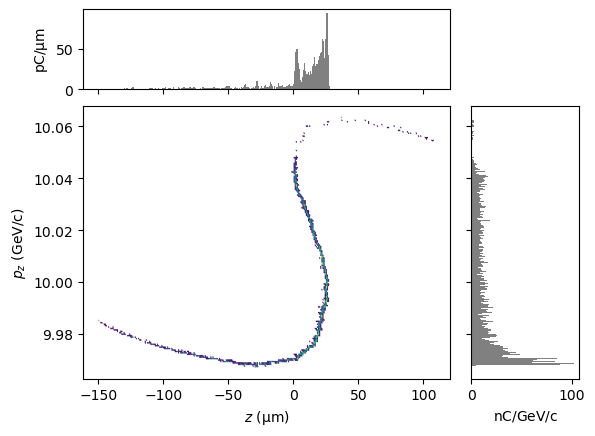

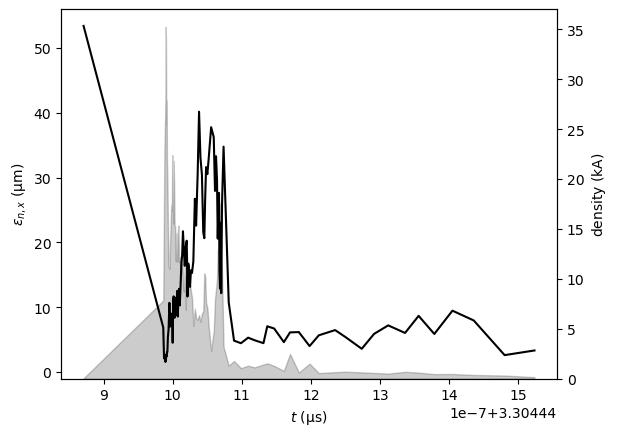

In [11]:
display(plotMod(P, 'x', 'y',  bins=300))
display(plotMod(P, 'x', 'pz', bins=300))
display(plotMod(P, 'x', 'xp', bins=300))
display(plotMod(P, 'y', 'yp', bins=300))
display(plotMod(P, 'z', 'pz', bins=300))
display(slicePlotMod(P, 'norm_emit_x',n_slice=100))

## Further study at other elements

In [12]:
?calcBMAG

Signature: calcBMAG(b0, a0, b, a)
Docstring: <no docstring>
File:      ~/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py
Type:      function

In [13]:
#def addBMAGToDict(dict, targetBeta, targetAlpha)

In [14]:
P = getBeamAtElement(tao, "PR10571")
#PDrive, PWitness = getDriverAndWitness(P)


#PR10571 lucretia live model lattice 2024-10-16
targetBetaX = 5.7
targetBetaY = 2.6
targetAlphaX = -2.1
targetAlphaY = 0.0

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
#PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

System BMAG:  1.026453572595337, 1.0083168005178793

System emit:  2.305462078882662e-06, 1.6980334884129927e-06


In [15]:
P = getBeamAtElement(tao, "BEGBC20")
#PDrive, PWitness = getDriverAndWitness(P)


#BEGBC20 lucretia live model lattice 2024-10-16
targetBetaX = 11.5
targetBetaY = 27.3
targetAlphaX = 0.7
targetAlphaY = 1.2

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
#PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)


#print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
#print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print()

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")


System BMAG:  1.1907641163136813, 1.3836088328759533

System emit:  3.4340603299948845e-06, 2.125234218281362e-06


In [16]:
P = getBeamAtElement(tao, "MFFF")
#PDrive, PWitness = getDriverAndWitness(P)
PDrive = P


#MFFF lucretia live model lattice 2024-10-16
targetBetaX = 11.6
targetBetaY = 25.2
targetAlphaX = -0.64
targetAlphaY = -1.6

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)


print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

print()

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

Drive beta x / y: 14.82052113355812, 16.50091810365798
Drive alpha x / y: -1.6429767258725039, -1.5225383725995556

System BMAG:  1.2967160216566256, 1.2631781179652142

System emit:  1.1388121964218906e-05, 2.0273743380135078e-06


In [17]:
P = getBeamAtElement(tao, "PENT")
#PDrive, PWitness = getDriverAndWitness(P)

#PENT lucretia live model lattice 2024-10-16
targetBetaX = 0.5
targetBetaY = 0.5
targetAlphaX = 0.0
targetAlphaY = 0.0

PTwiss = P.twiss(plane = "x", fraction = 0.9) | P.twiss(plane = "y", fraction = 0.9)
#PDriveTwiss = PDrive.twiss(plane = "x", fraction = 0.9) | PDrive.twiss(plane = "y", fraction = 0.9)
#PWitnessTwiss = PWitness.twiss(plane = "x", fraction = 0.9) | PWitness.twiss(plane = "y", fraction = 0.9)

print(f"""System beta x / y: {PTwiss["beta_x"]}, {PTwiss["beta_y"]}""")
print(f"""System alpha x / y: {PTwiss["alpha_x"]}, {PTwiss["alpha_y"]}""")

#print(f"""Drive beta x / y: {PDriveTwiss["beta_x"]}, {PDriveTwiss["beta_y"]}""")
#print(f"""Drive alpha x / y: {PDriveTwiss["alpha_x"]}, {PDriveTwiss["alpha_y"]}""")

#print(f"""Witness beta x / y: {PWitnessTwiss["beta_x"]}, {PWitnessTwiss["beta_y"]}""")
#print(f"""Witness alpha x / y: {PWitnessTwiss["alpha_x"]}, {PWitnessTwiss["alpha_y"]}""")

print(f"""System BMAG:  {calcBMAG(targetBetaX, targetAlphaX, PTwiss["beta_x"], PTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PTwiss["beta_y"], PTwiss["alpha_y"])}""")
#print(f"""Drive BMAG:   {calcBMAG(targetBetaX, targetAlphaX, PDriveTwiss["beta_x"], PDriveTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PDriveTwiss["beta_y"], PDriveTwiss["alpha_y"])}""")
#print(f"""Witness BMAG: {calcBMAG(targetBetaX, targetAlphaX, PWitnessTwiss["beta_x"], PWitnessTwiss["alpha_x"])}, {calcBMAG(targetBetaY, targetAlphaY, PWitnessTwiss["beta_y"], PWitnessTwiss["alpha_y"])}""")

print() 

print(f"""System emit:  {PTwiss["norm_emit_x"]}, {PTwiss["norm_emit_y"]}""")
#print(f"""Drive emit:   {PDriveTwiss["norm_emit_x"]}, {PDriveTwiss["norm_emit_y"]}""")
#print(f"""Witness emit: {PWitnessTwiss["norm_emit_x"]}, {PWitnessTwiss["norm_emit_y"]}""")

System beta x / y: 1.2331746575028524, 1.1615668100385588
System alpha x / y: 1.7241286815852583, -0.03221936803949416
System BMAG:  2.038539024686122, 1.3770167693146065

System emit:  1.1073234929966345e-05, 1.9933994512552666e-06


PR10571


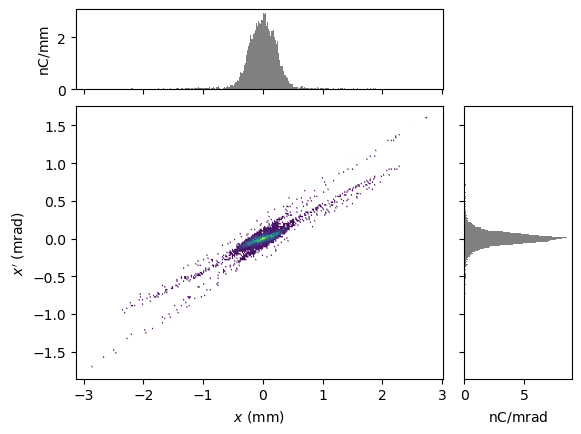

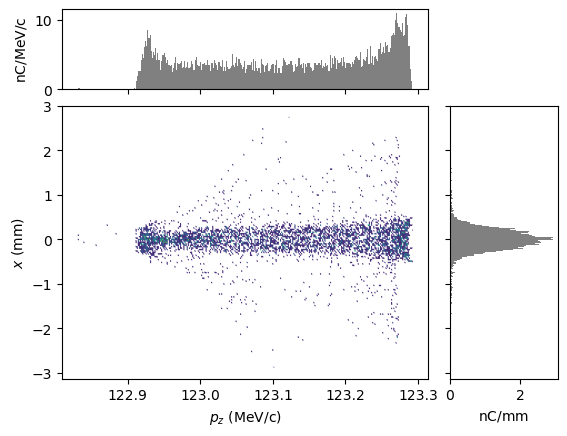

BEGBC20


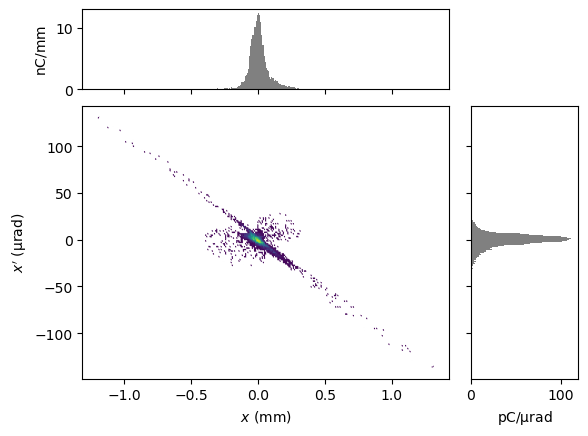

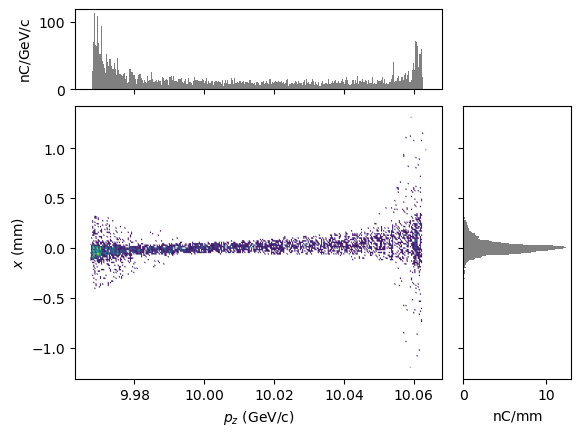

MFFF


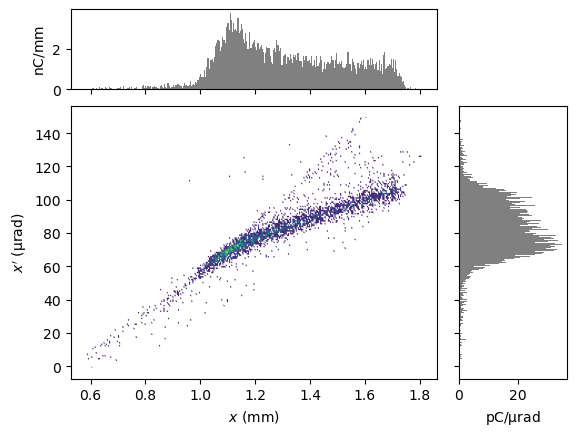

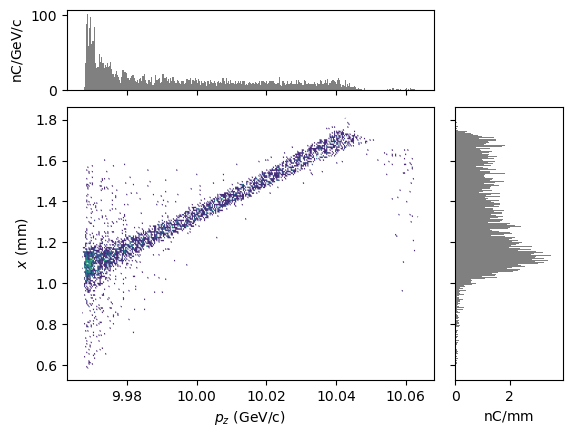

PENT


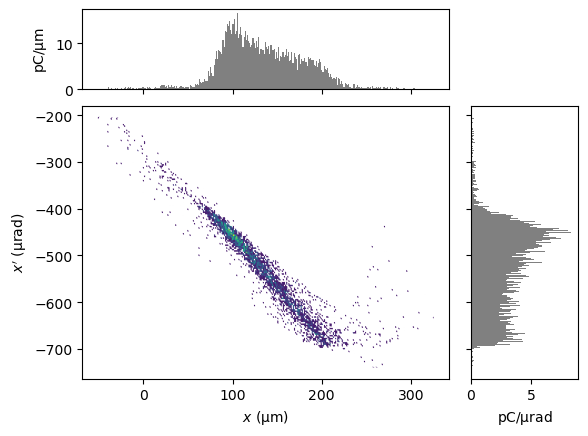

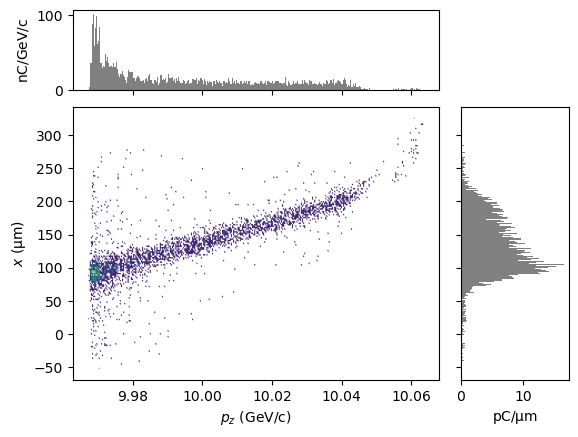

In [18]:

for activeElement in ["PR10571", "BEGBC20", "MFFF", "PENT"]:
    print(activeElement)
    P = getBeamAtElement(tao, activeElement)
    #PDrive, PWitness = getDriverAndWitness(P)
    
    display(plotMod(P, 'x', 'xp',  bins=300))
    display(plotMod(P, 'pz', 'x',  bins=300))

# Check beam specs at treaty points

In [19]:
print("DL10")
getMatrix(tao,"LH10END", "BEGL1F",print=True);
print("BC11")
getMatrix(tao,"BEGBC11_1", "BEGL2F",print=True);
print("BC14")
getMatrix(tao,"ENDL2F", "BEGL3F_1",print=True);
print("BC20")
getMatrix(tao,"BEGBC20", "MFFF",print=True);

DL10


4.295579,-1.134397,0.000000,0.000000,0.000000,0.000000
-0.918807,0.475440,-0.000000,-0.000000,0.000000,-0.000000
0.000000,0.000000,-0.739810,-2.140839,0.000000,-0.000000
0.000000,0.000000,-0.052968,-1.504974,0.000000,0.000000
0.000000,0.000000,0.000000,0.000000,1.000000,-0.006136
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


BC11


5.503387,-24.775546,0.000000,0.000000,0.000000,-0.000000
-0.203411,1.097438,-0.000000,-0.000000,0.000000,0.000000
-0.000000,0.000000,0.353439,2.781447,0.000000,0.000000
0.000000,-0.000000,-0.601774,-1.906419,0.000000,-0.000000
-0.000000,0.000000,-0.000000,-0.000000,1.000000,0.046019
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


BC14


-0.008002,17.783581,0.000000,0.000000,0.000000,0.000007
-0.056770,1.195609,0.000000,-0.000000,0.000000,0.000001
0.000000,0.000000,-1.165446,35.842067,0.000000,0.000000
-0.000000,-0.000000,-0.003119,-0.762114,0.000000,-0.000000
-0.000000,-0.000016,-0.000000,0.000000,1.000000,0.036014
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


BC20


-1.218683,-4.973529,-0.000000,-0.000000,0.000000,0.000655
-0.089198,-1.184581,0.000000,0.000000,0.000000,0.000025
-0.000000,-0.000000,-0.618300,6.832510,0.000000,-0.000000
-0.000000,-0.000000,-0.093640,-0.582575,0.000000,-0.000000
-0.000028,-0.000653,0.000000,0.000000,1.000000,-0.007041
0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [20]:
P = getBeamAtElement(tao, "L0BFEND")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")
print(f"""SI90 emittance: {1e6 * smallestIntervalImpliedEmittance(P, plane = "x")}, {1e6 * smallestIntervalImpliedEmittance(P, plane = "y")} um-rad""")
print(f"""norm_emit: {1e6 * P["norm_emit_x"]}, {1e6 * P["norm_emit_y"]} um-rad""")

E: 0.12311745211199861 GeV 
sig_z: 570.929744755693 um
sig_E: 0.08550572997828781 %
SI90 emittance: 3.0683531702888054, 2.963233089171267 um-rad
norm_emit: 6.564052463343808, 5.284783884865926 um-rad


/Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao/UTILITY_quickstart.py:383: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigmax**2 + 2 * z * rho * sigmax * sigmaxp + z**2 * sigmaxp**2)


In [21]:
P = getBeamAtElement(tao, "BEGL2F")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")

E: 0.3317396857742808 GeV 
sig_z: 370.0279354607662 um
sig_E: 0.42184459243292394 %


In [22]:
P = getBeamAtElement(tao, "BEGL3F_1")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")

E: 4.4192526452882035 GeV 
sig_z: 98.43247551167994 um
sig_E: 1.2538197579226176 %


In [23]:
P = getBeamAtElement(tao, "BEGBC20")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")
print(f"""emittance: {1e6 * smallestIntervalImpliedEmittance(P, plane = "x")}, {1e6 * smallestIntervalImpliedEmittance(P, plane = "y")} um-rad""")

E: 10.009132276178459 GeV 
sig_z: 98.41607894101996 um
sig_E: 0.2753980420307403 %
emittance: 11.278339720175314, 3.1879344314055977 um-rad


In [24]:
P = getBeamAtElement(tao, "PENT")
print(f"""E: {1e-9 * P["mean_energy"]} GeV """)
print(f"""sig_z: {1e6 * smallestIntervalImpliedSigma(P.z)} um""")
print(f"""sig_E: {100 * smallestIntervalImpliedSigma(P.energy)/P["mean_energy"]} %""")

E: 9.99613444478578 GeV 
sig_z: 26.754411138974074 um
sig_E: 0.2036228538511012 %


In [25]:
importedDefaultSettings

{'QA10361kG': -3.1976079537,
 'QA10371kG': 3.1129092742,
 'QE10425kG': -6.8469996218,
 'QE10441kG': 1.5057761462,
 'QE10511kG': 7.0138622173,
 'QE10525kG': -5.3942250594,
 'B1EkG': 7.533,
 'B2EkG': -10.942,
 'B3EkG': 3.409,
 'Q1EkG': 161.311,
 'Q2EkG': -154.229,
 'Q3EkG': 110.217,
 'Q4EkG': 132.268,
 'Q5EkG': -23.373,
 'Q6EkG': -142.271,
 'symmetricSextupoleStrengths': False,
 'S1ELkG': 804.871,
 'S2ELkG': -2049.489,
 'S3ELkG': -1019.323,
 'S3ERkG': -1019.323,
 'S2ERkG': -2049.489,
 'S1ERkG': 804.871,
 'Q5FFkG': -71.837,
 'Q4FFkG': -81.251,
 'Q3FFkG': 99.225,
 'Q2FFkG': 126.35,
 'Q1FFkG': -235.218,
 'Q0FFkG': 126.353,
 'Q0DkG': -109.694,
 'Q1DkG': 180.862,
 'Q2DkG': -109.694,
 'S1EL_xOffset': 0.0,
 'S1EL_yOffset': 0.0,
 'S2EL_xOffset': 0.0,
 'S2EL_yOffset': 0.0,
 'S2ER_xOffset': 0.0,
 'S2ER_yOffset': 0.0,
 'S1ER_xOffset': 0.0,
 'S1ER_yOffset': 0.0,
 'XC1FFkG': 0.0,
 'XC3FFkG': 0.0,
 'YC1FFkG': 0.0,
 'YC2FFkG': 0.0,
 'QA10361kGBounds': '(-10.1, 10.2)',
 'QA10371kGBounds': '(-10.1, 10.1)

L0AFEND


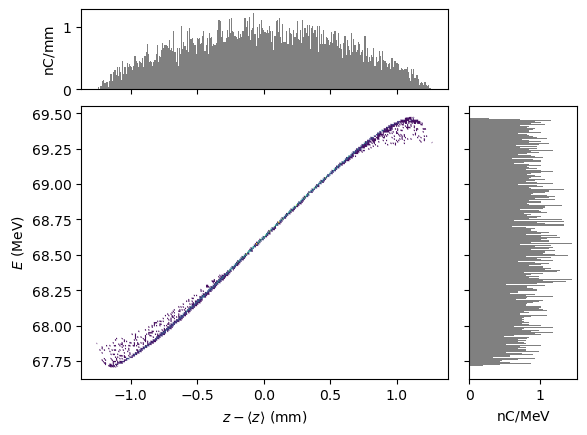

BEGL2F


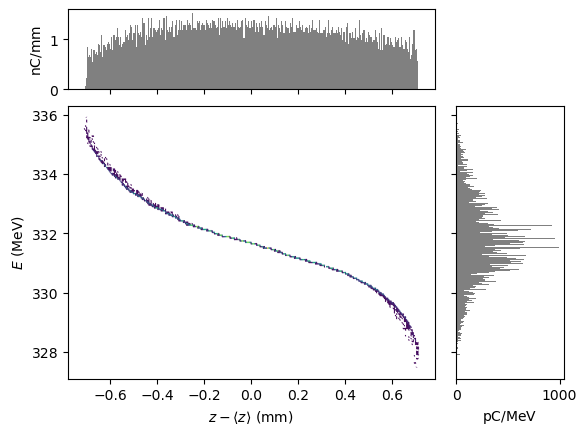

BEGL3F_1


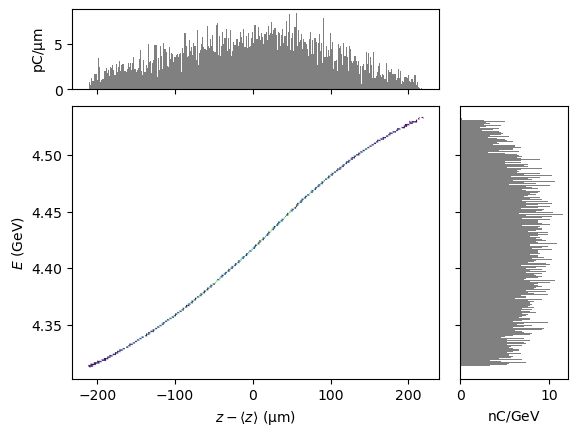

BEGBC20


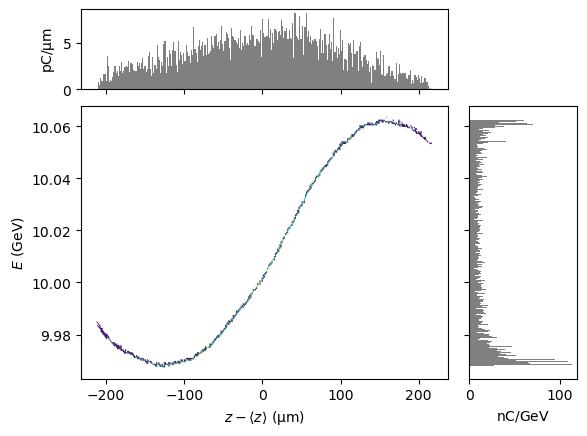

PENT


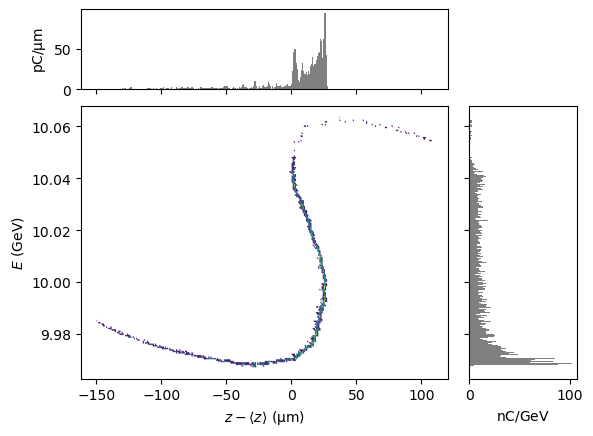

In [26]:
for activeElement in ["L0AFEND","BEGL2F","BEGL3F_1", "BEGBC20", "PENT"]:
    print(activeElement)
    P = getBeamAtElement(tao, activeElement)
    display(plotMod(P, 'delta_z', 'energy',  bins=300))

In [27]:
# for activePhase in np.arange(-40, -25, 1):
#     print(activePhase)
#     setLinacPhase(tao, "L2", activePhase)
#     setLinacGradientAuto(tao, "L2", 4.5e9 - 0.335e9)
#     trackBeam(tao)

#     # for activeElement in ["BEGBC20", "PENT"]:
#     #     P = getBeamAtElement(tao, activeElement)
#     #     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     #     display(plotMod(P, 'delta_z', 'energy',  bins=300))

#     activeElement = "BEGBC20"
#     P = getBeamAtElement(tao, activeElement)
#     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.5e-3, 0.5e-3), ylim = (9.5e9, 10.5e9) ) )

#     activeElement = "PENT"
#     P = getBeamAtElement(tao, activeElement)
#     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.2e-3, 0.2e-3), ylim = (9.6e9, 10.2e9) ) )
    

In [28]:
# for activePhase in np.arange(-34, -33, 0.1):
#     print(activePhase)
#     setLinacPhase(tao, "L2", activePhase)
#     setLinacGradientAuto(tao, "L2", 4.5e9 - 0.335e9)
#     trackBeam(tao)

#     # for activeElement in ["BEGBC20", "PENT"]:
#     #     P = getBeamAtElement(tao, activeElement)
#     #     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     #     display(plotMod(P, 'delta_z', 'energy',  bins=300))

#     activeElement = "BEGBC20"
#     P = getBeamAtElement(tao, activeElement)
#     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.1e-3, 0.1e-3), ylim = (9.6e9, 10.0e9) ) )

#     activeElement = "PENT"
#     P = getBeamAtElement(tao, activeElement)
#     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.1e-3, 0.1e-3), ylim = (9.6e9, 10.0e9) ) )

In [29]:
# for activePhase in np.arange(-75, 0, 5):
#     print(activePhase)
#     setLinacPhase(tao, "L3", activePhase)
#     setLinacGradientAuto(tao, "L3", 10e9 - 4.5e9)
#     trackBeam(tao)

#     # for activeElement in ["BEGBC20", "PENT"]:
#     #     P = getBeamAtElement(tao, activeElement)
#     #     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     #     display(plotMod(P, 'delta_z', 'energy',  bins=300))

#     activeElement = "BEGBC20"
#     P = getBeamAtElement(tao, activeElement)
#     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.5e-3, 0.5e-3), ylim = (9.5e9, 10.5e9) ) )

#     activeElement = "PENT"
#     P = getBeamAtElement(tao, activeElement)
#     print(f"""{activeElement}: {P["sigma_energy"]/1e6}""")
#     display(plotMod(P, 'delta_z', 'energy',  bins=300 , xlim = (-0.2e-3, 0.2e-3), ylim = (9.6e9, 10.2e9) ) )